# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd
import sklearn as skl
import pandas as pd
from PIL import Image
import warnings
import seaborn as sns
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from torcheval.metrics.metric import Metric
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassConfusionMatrix
from torcheval.metrics import MulticlassF1Score

from torcheval.metrics import BinaryAccuracy
from torcheval.metrics import BinaryPrecision
from torcheval.metrics import BinaryRecall
from torcheval.metrics import BinaryConfusionMatrix
from torcheval.metrics import BinaryF1Score

from torcheval.metrics import MeanSquaredError

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
gtzan_dir = Path(str(os.environ.get('GTZAN_DIR')))   #C:/VisualStudioRepositories/MUSIC_DATA/gt/Data
fma_dir = Path(str(os.environ.get('FMA_DIR')))       #C:/VisualStudioRepositories/MUSIC_DATA/fma

gtzan_image_dir = gtzan_dir / 'spectrograms'
gtzan_df_path = gtzan_dir / 'gtzan_df.csv'

fma_small_image_dir = fma_dir / 'spectrograms/fma_small'
fma_medium_image_dir = fma_dir / 'spectrograms/fma_medium'
fma_df_path = fma_dir / 'fma_df.csv'

In [4]:
report_output_root_dir = Path('../output/txt')

report_output_dirs = {'gtzan_multi': report_output_root_dir / 'gtzan_multi',
                      'fma_small_multi': report_output_root_dir / 'fma_small_multi',
                      'fma_medium_multi': report_output_root_dir / 'fma_medium_multi',
                      
                      'gtzan_binary': report_output_root_dir / 'gtzan_binary',
                      'fma_small_binary': report_output_root_dir / 'fma_small_binary',
                      'fma_medium_binary': report_output_root_dir / 'fma_medium_binary'}

In [5]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10

fma_small_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

fma_medium_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock',
                          'Easy Listening', 'Blues', 'Soul-RnB', 'Spoken', 'Country', 'Jazz', 'Old-Time / Historic', 'Classical'] #16

In [6]:
IMAGE_SIZE = 128    #128x128 px images for the CNN (with 3 channels)

# Clean output directories

In [68]:
for dir_path in report_output_dirs.values():
    for file_path in dir_path.glob('*.txt'):
        file_path.unlink()
    for file_path in dir_path.glob('*.png'):
        file_path.unlink()

# Define function loading GTZAN df from file

In [7]:
def get_gtzan_dataframe(with_val):
    gtzan_df = pd.read_csv(gtzan_df_path)
    
    # turn relative paths into absolute paths
    gtzan_df['path'] = gtzan_df['path'].apply(lambda x: gtzan_image_dir / x)
    
    # SAMPLES: 800/98/100
    if (with_val):
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_val_df = gtzan_df[gtzan_df['set'] == 'validation']
        gtzan_test_df = gtzan_df[gtzan_df['set'] == 'test']
        return gtzan_train_df, gtzan_val_df, gtzan_test_df
    else: # SAMPLES: 800/198
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_test_df = gtzan_df[(gtzan_df['set'] == 'test') | (gtzan_df['set'] == 'validation')]
        return gtzan_train_df, gtzan_test_df

# Load GTZAN df (with/without separate val set)

In [8]:
# with separate val
gtzan_train_df, gtzan_val_df, gtzan_test_df = get_gtzan_dataframe(with_val=True)

In [13]:
# without separate val
gtzan_train_df, gtzan_test_df = get_gtzan_dataframe(with_val=False)

# Define function loading FMA df from file

In [ ]:
def get_fma_dataframe(get_fma_small, with_val):
    fma_df = pd.read_csv(fma_df_path)
    
    # turn relative paths into absolute paths
    fma_df['path'] = fma_df['path'].apply(lambda x: fma_medium_image_dir / x)
    
    # otherwise the dataset is FMA-medium
    if (get_fma_small):
        fma_df = fma_df[fma_df['size'] == 'small']
    
    # PERCENTAGES: 80/10/10
    if (with_val):
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_val_df = fma_df[fma_df['set'] == 'validation']
        fma_test_df = fma_df[fma_df['set'] == 'test']
        return fma_train_df, fma_val_df, fma_test_df
    else: # PERCENTAGES: 80/20
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_test_df = fma_df[(fma_df['set'] == 'test') | (fma_df['set'] == 'validation')]
        return fma_train_df, fma_test_df

# Load FMA df (with/without separate val set) (small/medium)

In [ ]:
# fma-small with separate val
fma_small_train_df, fma_small_val_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=True)

In [ ]:
# fma-small without separate val
fma_small_train_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=False)

In [ ]:
# fma-medium with separate val
fma_medium_train_df, fma_medium_val_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=True)

In [ ]:
# fma-medium without separate val
fma_medium_train_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=False)

# Define input data loading functions - PyTorch

In [9]:
# 0, 1, 2, 3... labels used with nn.CrossEntropyLoss
def numerically_encode_class_label(class_name, available_classes):
  return available_classes.index(class_name)

# currently unused
def one_hot_encode_class_label(class_name, available_classes):
  label = available_classes.index(class_name)
  one_hot = np.zeros(len(available_classes))
  one_hot[label] = 1
  return one_hot

# decode png
def decode_img_data(img_path, channels=3):
  img = Image.open(img_path).convert('RGB' if channels == 3 else 'L') # convert to RGB if 3 channels, otherwise grayscale
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = np.array(img)
  img = torch.tensor(img).permute(2, 0, 1) if channels == 3 else torch.tensor(img).unsqueeze(0) # channels first
  return img.float() / 255.0 # normalize to [0, 1]

# return pair: decoded png and class name turned into numerical label
def process_sample(sample, available_classes, channels=3):
  img_path = sample[0]
  class_label = sample[1]
  
  img_data = decode_img_data(img_path, channels)
  numerical_label = numerically_encode_class_label(class_label, available_classes)
  return img_data, numerical_label

In [10]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, available_classes, channels=3):
        self.df = df
        self.available_classes = available_classes
        self.channels = channels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        class_label = self.df.iloc[idx]['genre']
        img_data, numerical_label = process_sample((img_path, class_label), self.available_classes, self.channels)
        return img_data.to(device), torch.tensor(numerical_label, device=device) #! DATA on device

def prepare_dataloader_based_on_df(df, available_classes, batch_size=8, channels=3):
    dataset = CustomDataset(df, available_classes, channels)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    return dataloader

In [11]:
def visualize_samples_from_dataloader_batch(dl, available_classes, samples=6):
    image_batch, label_batch = next(iter(dl))
    samples = samples if samples <= len(label_batch) else len(label_batch)
    
    fig, axes = plt.subplots(ncols=3, nrows=(samples + 2) // 3)
    [axis.set_axis_off() for axis in axes.ravel()]
    
    for i in range(samples):
        ax = axes.flat[i]
        img = image_batch[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.set_title(available_classes[torch.argmax(label_batch[i]).item()])

# Create GTZAN DataLoaders

With val

In [12]:
BATCH_SIZE = 32
CHANNELS = 3

In [13]:
gtzan_train_dl = prepare_dataloader_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_val_dl = prepare_dataloader_based_on_df(gtzan_val_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_test_dl = prepare_dataloader_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS)

# Visualize GTZAN from DataLoader

Done on CPU

In [ ]:
visualize_samples_from_dataloader_batch(gtzan_test_dl, gtzan_classes, samples=6)

# CNN model - PyTorch

In [14]:
# 4 convolutional layers
# layer 1 and 2:
#   64 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#   
# layer 3 and 4:
#   128 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#
# dropout 0.2
#
# output:
#   fully connected linear layer

class CNN(nn.Module):
    def __init__(self, img_size, channels, num_outputs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Calculate the size of the flattened feature map
        self.flattened_size = (img_size // 16) * (img_size // 16) * 128
        # max pooling reduces image width by /16 and image height by /16
        # 128 is the number of kernels in the last convolutional layer
        
        self.fc = nn.Linear(self.flattened_size, num_outputs) # Logits, not probabilities
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        
        x = x.view(-1, self.flattened_size)  # Flatten the feature map
        x = self.fc(x)
        
        return x

# Metrics - multiclass and binary

Custom metrics (scikit calculations wrapped in PyEval Metric)

In [42]:
# BINARY CLASSIFICATION (1 output neuron):
# logits -> sigmoid -> round -> predicted class indexes

# MULTI-CLASS CLASSIFICATION (N output neurons):
# logits -> argmax -> predicted classes indexes
def get_predicted_classes(predictions, is_binary):  # threshold for binary = 0.5
    return [torch.round(torch.sigmoid(pred)) for pred in predictions] if is_binary else [torch.argmax(pred) for pred in predictions]
    
def get_predicted_probabilities(predictions, is_binary):
    return [torch.sigmoid(pred) for pred in predictions] if is_binary else [F.softmax(pred, dim=0) for pred in predictions]
    
def get_binary_labels_for_class(labels, class_index):
    return [1 if label == class_index else 0 for label in labels]

In [16]:
class CohenKappa(Metric[torch.Tensor]):
    def __init__(self, is_binary, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = is_binary
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_classes", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        predicted = torch.tensor(get_predicted_classes(prediction_logits, self.is_binary), device=self.device)
        
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_classes = torch.cat((self.predicted_classes, predicted))
        return self

    @torch.inference_mode()
    def compute(self): 
        return cohen_kappa_score( self.true_classes.cpu().detach().numpy(), self.predicted_classes.cpu().detach().numpy() )

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_classes_2 = [self.predicted_classes, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_classes_2.append(metric.predicted_classes_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_classes = torch.cat(predicted_classes_2)
        return self

In [17]:
# SCIKIT INFORMATION:
# multiclass:
# raise-> used for binary classification, raises error when input is mistakenly multiclass.
# ovr  -> one vs REST (AUNu or AUNp)
#         Computes the AUC of each class against the rest. This treats the multiclass case in the same way as the multilabel case.
#         Sensitive to class imbalance even when average == 'macro', because class imbalance affects
#         the composition of each of the ‘rest’ groupings.         
# ovo  -> one vs ONE (AU1u or AU1p)
#         Computes the average AUC of all possible pairwise combinations of classes.
#         Insensitive to class imbalance when average == 'macro'.

# average:
# None     -> AUC score for each class. For multiclass: None implemented only for OVR
# macro    -> Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
# micro    -> Calculate metrics globally by considering each element of the label indicator matrix as a label.
# weighted -> Calculate metrics for each label, and find their average,
#             weighted by support (the number of true instances for each label).
# samples  -> calculated for each sample

# combinations:
# raise + macro  ->    binary AUC
# ovr + macro    ->    AUNu
# ovr + weighted ->    AUNp
# ovo + macro    ->    AU1u
# ovo + weighted ->    AU1p
# ovr + None     ->    multiclass AUC per class (vs rest)
class ROCAUC(Metric[torch.Tensor]):
    def __init__(self, multiclass, average, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = multiclass == 'raise'
        self.multiclass = multiclass
        self.average = average
 
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_probabilities", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        probabilities = torch.stack(get_predicted_probabilities(prediction_logits, self.is_binary)).clone().detach()      
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_probabilities = torch.cat((self.predicted_probabilities, probabilities))
        return self

    @torch.inference_mode()
    def compute(self):     
        return roc_auc_score(y_true=self.true_classes.cpu().detach().numpy(),
                             y_score=self.predicted_probabilities.cpu().detach().numpy(),
                             multi_class=self.multiclass,
                             average=self.average)

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predictions_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self

In [18]:
drawn_binary_ROC = 'drawn_binary_ROC'
drawn_multi_ROC = 'drawn_multi_ROC'
drawn_AUNu = 'drawn_AUNu'
drawn_ROC_list = [drawn_binary_ROC, drawn_multi_ROC, drawn_AUNu]

In [19]:
# used just to draw the ROC curve, roc_curve does not have the same built-in options roc_curve_score does
class drawn_ROC_curve(Metric[torch.Tensor]):
    def __init__(self, n_classes, device = None) -> None:
        super().__init__(device=device)
        
        self.is_binary = n_classes == 2
        self.n_classes = n_classes
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_probabilities", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        probabilities = torch.stack(get_predicted_probabilities(prediction_logits, self.is_binary)).clone().detach()      
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_probabilities = torch.cat((self.predicted_probabilities, probabilities))       
        return self
    
    @torch.inference_mode()
    def calculate_FPRs_TPRs(self):
        fprs, tprs = dict(), dict()
        for i in range(self.n_classes):
            binary_labels_for_class = get_binary_labels_for_class(self.true_classes.cpu().detach().numpy(), i)
            fprs[i], tprs[i], _ = roc_curve(y_true=binary_labels_for_class, y_score=self.predicted_probabilities[:, i].cpu().detach().numpy())
        return fprs, tprs
        
    # implemented in subclasses
    @torch.inference_mode()
    def compute(self):  
        pass

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predictions_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self

In [20]:
class drawn_binary_ROC_curve(drawn_ROC_curve):
    def __init__(self, device = None) -> None:
        super().__init__(n_classes=2, device=device)
        
    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        super().update(prediction_logits, labels)

    @torch.inference_mode()
    def compute(self):  
        return roc_curve(y_true=self.true_classes.cpu().detach().numpy(), y_score=self.predicted_probabilities.cpu().detach().numpy())

In [21]:
# one vs rest, macro average
class drawn_AUNu_curve(drawn_ROC_curve):
    def __init__(self, n_classes, device = None) -> None:
        super().__init__(n_classes=n_classes, device=device)
        
    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        super().update(prediction_logits, labels)
        
    @torch.inference_mode()
    def calculate_macro_fpr_tpr(self):
        fprs, tprs = super().calculate_FPRs_TPRs()

        fpr_grid = np.linspace(0.0, 1.0, 1000)
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(self.n_classes):
            mean_tpr += np.interp(fpr_grid, fprs[i], tprs[i])  # linear interpolation

        mean_tpr /= self.n_classes  
        return fpr_grid, mean_tpr

    @torch.inference_mode()
    def compute(self):  
        return self.calculate_macro_fpr_tpr()

In [22]:
# one vs rest, separate AUC for each class
class drawn_multi_ROC_curve(drawn_ROC_curve):
    def __init__(self, n_classes, device = None) -> None:
        super().__init__(n_classes, device)
        
    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        super().update(prediction_logits, labels)

    @torch.inference_mode()
    def compute(self):  
        return super().calculate_FPRs_TPRs()

Multiclass metrics

In [23]:
# Basic metric set calculated and displayed:
# - EVERY TRAINING loop
# - EVERY VALIDATION loop.
# Its metrics are included in the full metric set.
def create_basic_multiclass_metrics(num_classes):
    return { "macro_accuracy": MulticlassAccuracy(device=device, average='macro', num_classes=num_classes),
             "micro_accuracy": MulticlassAccuracy(device=device, average='micro'),
             "accuracy_per_class": MulticlassAccuracy(device=device, average=None, num_classes=num_classes),
             
             "macro_f1": MulticlassF1Score(device=device, average='macro', num_classes=num_classes), 
            }
    
# Full metric set (contains basic set) calculated and displayed on:
# - LAST VALIDATION loop
# - TEST loop
# This is done to reduce clutter in the output and to calculate the full metric set
# only when the results are most useful.
def create_full_multiclass_metrics(num_classes):
    basic_metrics = create_basic_multiclass_metrics(num_classes)
    return { **basic_metrics,
            
             "micro_f1": MulticlassF1Score(device=device, average='micro'),
             "f1_per_class": MulticlassF1Score(device=device, average=None, num_classes=num_classes),
            
             "macro_precision": MulticlassPrecision(device=device, average='macro', num_classes=num_classes),
             "micro_precision": MulticlassPrecision(device=device, average='micro'),
             "precision_per_class": MulticlassPrecision(device=device, average=None, num_classes=num_classes),
             
             "macro_recall": MulticlassRecall(device=device, average='macro', num_classes=num_classes),
             "micro_recall": MulticlassRecall(device=device, average='micro'),
             "recall_per_class": MulticlassRecall(device=device, average=None, num_classes=num_classes), 
             
             # Probabilistic metrics
             #"MSE": MeanSquaredError(device=device),
             #"CrossEntropyLoss": nn.CrossEntropyLoss(),
             
             # Rank metrics
             "AUNu": ROCAUC(device=device, multiclass='ovr', average='macro'),
             "AUNp": ROCAUC(device=device, multiclass='ovr', average='weighted'),
             "AU1u": ROCAUC(device=device, multiclass='ovo', average='macro'),
             "AU1p": ROCAUC(device=device, multiclass='ovo', average='weighted'),
             "ROC-AUC_per_class_vs_rest": ROCAUC(device=device, multiclass='ovr', average=None),
             
             drawn_AUNu: drawn_AUNu_curve(device=device, n_classes=num_classes),
             drawn_multi_ROC: drawn_multi_ROC_curve(device=device, n_classes=num_classes),
             
             # Confusion Matrix displayed last
             "confusion_matrix": MulticlassConfusionMatrix(device=device, num_classes=num_classes),
             }
    
# ROC-AUC using PyEval:
#"AUNU": MulticlassAUROC(device=device, average="macro", num_classes=num_classes), # ONE vs REST, macro average
#"ROC-AUC_per_class": MulticlassAUROC(device=device, average=None, num_classes=num_classes),    
# Scikit was chosen because it has more averaging options and can be used to draw curves

Note:

issue https://github.com/pytorch/torcheval/pull/199 for TorchEval mentions that the warning message for MulticlassPrecision(average=None) is misleading.

The warning says that both the ground truth AND predictions have n=0 for some classes, but in fact it takes only ground truth OR predictions to have n=0 for this warning to appear. So, if a model just never predicts a particular class in an epoch, this warning appears despite it not being an architectural mistake.

BCEWithLogitsLoss - turns out that it needs: outputs.squeeze(), labels.float()


Binary metrics

In [24]:
def create_basic_binary_metrics():
    return { "accuracy": BinaryAccuracy(device=device),
             "f1": BinaryF1Score(device=device),   
            }
    
def create_full_binary_metrics():
    basic_metrics = create_basic_binary_metrics()
    return { **basic_metrics,
                     
              "precision": BinaryPrecision(device=device),         
              "recall": BinaryRecall(device=device),                     
              "cohen's kappa": CohenKappa(device=device, is_binary=True),
              
              # Probabilistic metrics
              #"MSE": MeanSquaredError(device=device), 
              
              # Rank metrics
              "binary_ROC-AUC": ROCAUC(device=device, multiclass='raise', average='macro'),
              drawn_binary_ROC: drawn_binary_ROC_curve(device=device),
                  
              # Confusion Matrix displayed last
              "confusion_matrix": BinaryConfusionMatrix(device=device),
           }
    # PyEval:
    #"ROC-AUC": BinaryAUROC(device=device)

Tool methods to display metrics and to reset/update/compute them

In [25]:
# can be binary or multiclass
def draw_confusion_matrix(confusion_matrix, class_names, file_output=None):
    plt.figure(figsize=(7, 7))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, square=True, linewidths=0, linecolor='black')

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if file_output is not None:
        plt.savefig(file_output)
        
    plt.show()

In [26]:
def draw_binary_ROC_curve(ax, roc_curve):
    ax.set_title("ROC curve")
    fpr, tpr = roc_curve[0], roc_curve[1]
    RocCurveDisplay.from_predictions(fpr, tpr, ax=ax)
    
def draw_multi_ROC_curve(ax, roc_curve, class_names):
    ax.set_title("ROC curves, one vs rest")
    colors = plt.cm.get_cmap('tab10', len(class_names))
    for i in range(len(class_names)):
        fpr, tpr = roc_curve[0][i], roc_curve[1][i]
        ax.plot(
            fpr,
            tpr,
            color=colors(i),
            linewidth=2,
            label=class_names[i]
        )
    ax.legend(loc='lower right')
    
def draw_AUNu_curve(ax, roc_curve):
    ax.set_title("AU1u (one vs rest, macro average)")
    fpr, tpr = roc_curve[0], roc_curve[1]
    ax.plot(
        fpr,
        tpr,
        color="navy",
        linewidth=2,
    )

def draw_roc_curve(roc_curve, roc_type, class_names=None, file_output=None):
    fig, ax = plt.subplots(figsize=(6,6))
    
    if roc_type == drawn_binary_ROC:
        draw_binary_ROC_curve(ax, roc_curve)
    elif roc_type == drawn_multi_ROC:
        draw_multi_ROC_curve(ax, roc_curve, class_names)
    elif roc_type == drawn_AUNu:
        draw_AUNu_curve(ax, roc_curve)
    
    if file_output is not None:
        plt.savefig(file_output)
        
    plt.show(fig)

In [27]:
def reset_metrics(metrics):
    [metric.reset() for metric in metrics.values()]

# numerical labels: 0, 1, 2, 3, ...
def update_metrics(metrics, logits, numerical_labels):
    numerical_labels = numerical_labels.to(torch.int64)
    [metric.update(logits, numerical_labels) for metric in metrics.values()]

def compute_metrics(metrics):
    return {name: metric.compute() for name, metric in metrics.items()}

def print_single_metric(name, value, output=sys.stdout):
    print(f"{name}: {value:.4f}", file=output)
    
def print_metric_per_class(name, values, class_names, output=sys.stdout):
    print(f"{name}:", end=" ", file=output)
    [print(f"{class_names[i]}: {values[i]:.4f}", end=" ", file=output) for i in range(len(values))]
    print(file=output)
    
def print_metrics(metrics, class_names, output=sys.stdout): 
    for name, metric in metrics.items():
        
        if (name in drawn_ROC_list):          # print plot and if there is an output .txt report file provided, save the ROC curve as a corresponding png
            output_png = output.name.replace('.txt', f'_{name}.png') if output != sys.stdout else None
            draw_roc_curve(metric, name, class_names, output_png)
            continue
        
        value = metric.tolist()
        
        if (name == 'confusion_matrix'):      # print plot and if there is an output .txt report file provided, save the confusion matrix as a corresponding png
            output_png = output.name.replace('.txt', '_confmat.png') if output != sys.stdout else None
            draw_confusion_matrix(value, class_names, output_png)
            
        elif isinstance(value, list):         # one number result for each class
            print_metric_per_class(name, value, class_names, output)
        else:                                 # one number result for all classes
            print_single_metric(name, value, output)

In [28]:
# file creation order: 1.txt, 2.txt, 3.txt, ...
def create_next_report_file_name(output_dir_path):
    existing_files = list(output_dir_path.glob('*.txt'))
    if existing_files:
        existing_numbers = [int(f.stem) for f in existing_files if f.stem.isdigit()]
        next_number = max(existing_numbers) + 1
    else:
        next_number = 1
    return f'{next_number}.txt'

def write_results_report_to_new_file(output_dir_path, epochs, results, class_names):
    output_file = output_dir_path / create_next_report_file_name(output_dir_path)
    output_dir_path.mkdir(parents=True, exist_ok=True)
    with open(output_file, 'w') as f:
        f.write(f"EPOCHS: {epochs}\n")
        f.write('TEST results:\n')
        print_metrics(results, class_names, output=f)

# Training/Test loops - PyTorch

In [29]:
#==================================================================================  
# Test loop
#==================================================================================  
def test_loop(model, metrics, class_names, test_dl):
    is_binary_classification = len(class_names) == 2
    reset_metrics(metrics)
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not calculate gradients
        for inputs, labels in test_dl: # get batch (batch_size specified during DataLoader creation)
            outputs = model(inputs)                       # forward pass
            
            if is_binary_classification:
                outputs = outputs.squeeze()
                labels = labels.float()
            
            update_metrics(metrics, outputs, labels)      # update metrics after batch
    
    results_copy = compute_metrics(metrics) # calculate metrics after whole epoch
    print_metrics(results_copy, class_names)
    reset_metrics(metrics)
    return results_copy

In [30]:
# Training and optional validation at end of epoch
def training_loop(model, epochs, basic_metrics, class_names, train_dl, val_dl = None, full_metrics = None):
    is_binary_classification = len(class_names) == 2
    
    # PREDICTIONS: logits, LABELS: numerical
    loss_function = nn.BCEWithLogitsLoss() if is_binary_classification else nn.CrossEntropyLoss()   
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    reset_metrics(basic_metrics)
    
    #==================================================================================  
    # Training loop
    #==================================================================================  
    for epoch in range(epochs):
        model.train() # training mode
        running_loss = 0.0
        for inputs, labels in train_dl: # get batch (batch_size specified during DataLoader creation)
            optimizer.zero_grad()           # zero the parameter gradients
            outputs = model(inputs)         # forward pass
            
            if is_binary_classification:
                outputs = outputs.squeeze()
                labels = labels.float()
                     
            loss = loss_function(outputs, labels) # calculate loss (logits, numerical labels)
            update_metrics(basic_metrics, outputs, labels)
            
            loss.backward()                 # backward pass
            optimizer.step()                # optimize weights
            running_loss += loss.item()     # accumulate loss
            
        # Calculate, display and reset TRAINING loop metrics
        print("TRAINING=======") 
        print(f"[EPOCH {epoch+1}], LOSS: {running_loss/len(train_dl)}")   
        computed_basic_metrics = compute_metrics(basic_metrics)
        print_metrics(computed_basic_metrics, class_names)
        reset_metrics(basic_metrics)
        
        #==================================================================================  
        # VALIDATION at end of epoch if val_dl is provided
        #================================================================================== 
        if val_dl is not None:
            print("VALIDATION=======") 
            
            # Calculate and display FULL METRIC SET if its the LAST VALIDATION loop
            # and the full metric set was provided
            if epoch == epochs - 1 and full_metrics is not None:
                test_loop(model, full_metrics, class_names, val_dl)
            else:
                test_loop(model, basic_metrics, class_names, val_dl)
        
        print("=====================================")

# Create and train GTZAN model

In [46]:
EPOCHS_GTZAN_MULTI = 25

In [47]:
model_gtzan = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(gtzan_classes)).to(device) #! model to device

In [48]:
gtzan_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(gtzan_classes))
gtzan_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(gtzan_classes))

epochs: 25

| batch_size | val macro-accuracy | test macro-accuracy |
| ----| ------ |------|
| 32  | 64.4%  | 58%  |


TRAINING=======
[EPOCH 1], LOSS: 2.7845345067977907
macro_accuracy: 0.2313
micro_accuracy: 0.2313
accuracy_per_class: Blues: 0.1375 Classical: 0.3500 Country: 0.1875 Disco: 0.1500 Hip-Hop: 0.1625 Jazz: 0.1875 Metal: 0.5875 Pop: 0.3625 Reggae: 0.1375 Rock: 0.0500 
macro_f1: 0.2195
VALIDATION=======
macro_accuracy: 0.2000
micro_accuracy: 0.2041
accuracy_per_class: Blues: 0.1000 Classical: 0.0000 Country: 0.4000 Disco: 0.0000 Hip-Hop: 0.0000 Jazz: 0.0000 Metal: 0.7000 Pop: 0.8000 Reggae: 0.0000 Rock: 0.0000 
macro_f1: 0.1084
TRAINING=======
[EPOCH 2], LOSS: 1.9293584823608398
macro_accuracy: 0.3225
micro_accuracy: 0.3225
accuracy_per_class: Blues: 0.1625 Classical: 0.4125 Country: 0.3250 Disco: 0.2750 Hip-Hop: 0.1875 Jazz: 0.1500 Metal: 0.6250 Pop: 0.5250 Reggae: 0.2875 Rock: 0.2750 
macro_f1: 0.3174
VALIDATION=======
macro_accuracy: 0.2044
micro_accuracy: 0.2041
accuracy_per_class: Blues: 0.4000 Classical: 0.0000 Country: 0.0000 Disco: 0.0000 Hip-Hop: 1.0000 Jazz: 0.4444 Metal: 0.1000 Po

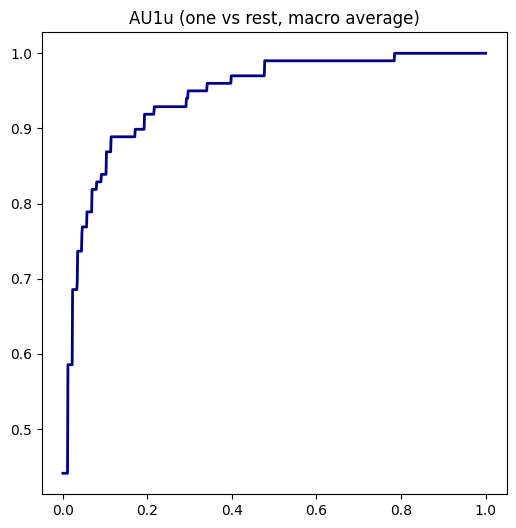

C:\Users\Operator\AppData\Local\Temp\ipykernel_17428\2337938561.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


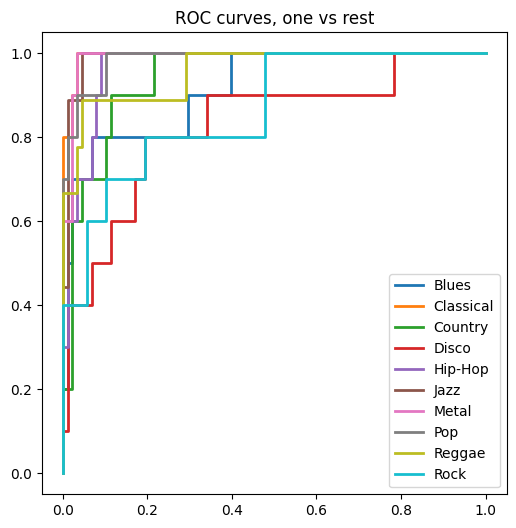

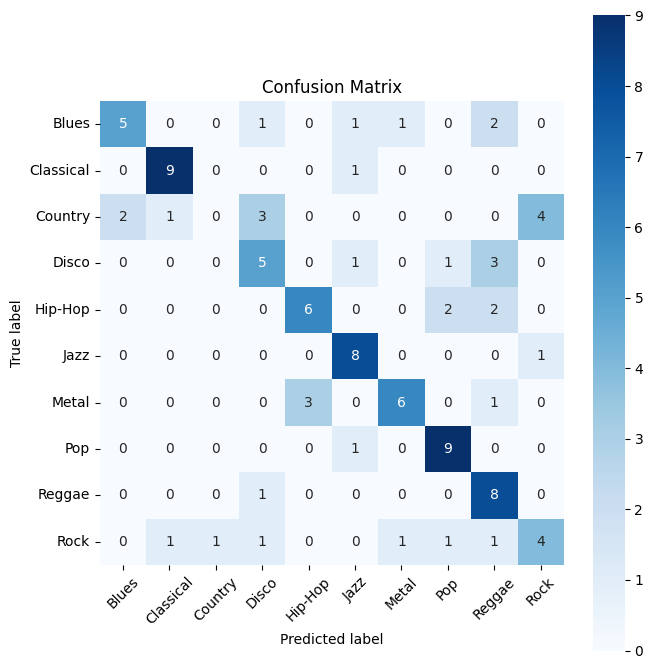

In [49]:
training_loop(model=model_gtzan,
              epochs=EPOCHS_GTZAN_MULTI,
              basic_metrics=gtzan_basic_multiclass_metrics,
              class_names=gtzan_classes,
              train_dl=gtzan_train_dl,
              val_dl=gtzan_val_dl,
              full_metrics=gtzan_full_multiclass_metrics)

macro_accuracy: 0.5800
micro_accuracy: 0.5800
accuracy_per_class: Blues: 0.3000 Classical: 0.9000 Country: 0.1000 Disco: 0.4000 Hip-Hop: 0.6000 Jazz: 0.7000 Metal: 0.9000 Pop: 0.8000 Reggae: 0.8000 Rock: 0.3000 
macro_f1: 0.5610
micro_f1: 0.5800
f1_per_class: Blues: 0.3529 Classical: 0.9474 Country: 0.1818 Disco: 0.3636 Hip-Hop: 0.5217 Jazz: 0.6364 Metal: 0.9474 Pop: 0.7273 Reggae: 0.6154 Rock: 0.3158 
macro_precision: 0.6307
micro_precision: 0.5800
precision_per_class: Blues: 0.4286 Classical: 1.0000 Country: 1.0000 Disco: 0.3333 Hip-Hop: 0.4615 Jazz: 0.5833 Metal: 1.0000 Pop: 0.6667 Reggae: 0.5000 Rock: 0.3333 
macro_recall: 0.5800
micro_recall: 0.5800
recall_per_class: Blues: 0.3000 Classical: 0.9000 Country: 0.1000 Disco: 0.4000 Hip-Hop: 0.6000 Jazz: 0.7000 Metal: 0.9000 Pop: 0.8000 Reggae: 0.8000 Rock: 0.3000 
AUNu: 0.9119
AUNp: 0.9119
AU1u: 0.9119
AU1p: 0.9119
ROC-AUC_per_class_vs_rest: Blues: 0.9000 Classical: 1.0000 Country: 0.9100 Disco: 0.8256 Hip-Hop: 0.8433 Jazz: 0.9322 Met

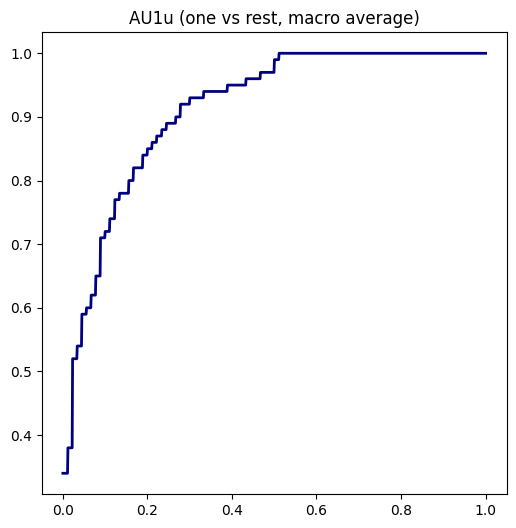

C:\Users\Operator\AppData\Local\Temp\ipykernel_17428\2337938561.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


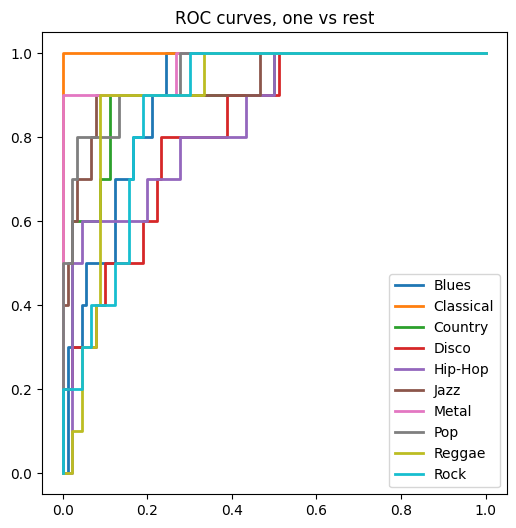

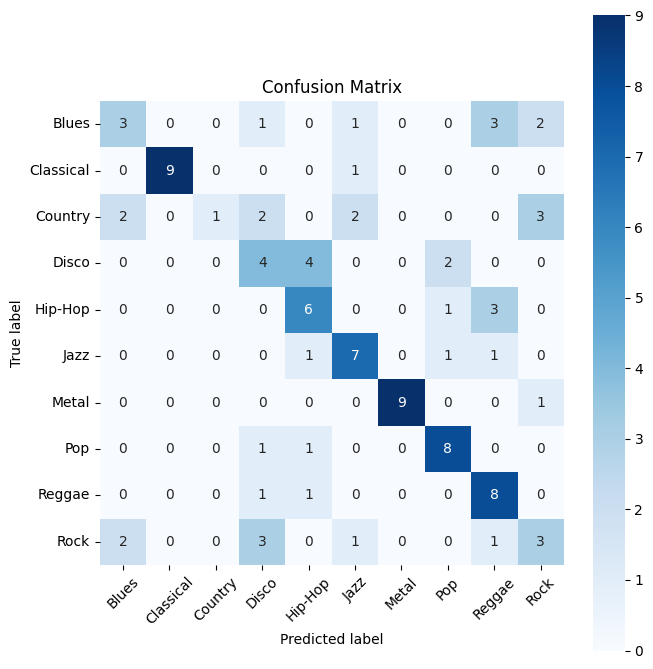

In [50]:
results = test_loop(model_gtzan, gtzan_full_multiclass_metrics, gtzan_classes, gtzan_test_dl)

Different micro and macro when a class has, for example, no TP in precision TP/(TP+FP)

Macro DOES count the 0, micro does not

Example:

(0.75+0.6+0.5714+0+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/10 = 0.53297

(0.75+0.6+0.5714+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/9 = 0.592

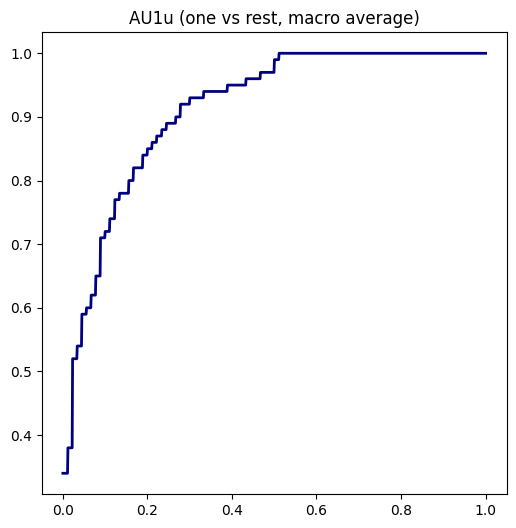

C:\Users\Operator\AppData\Local\Temp\ipykernel_17428\2337938561.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


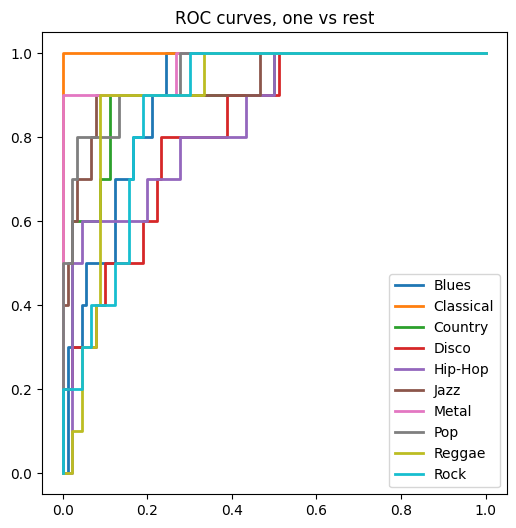

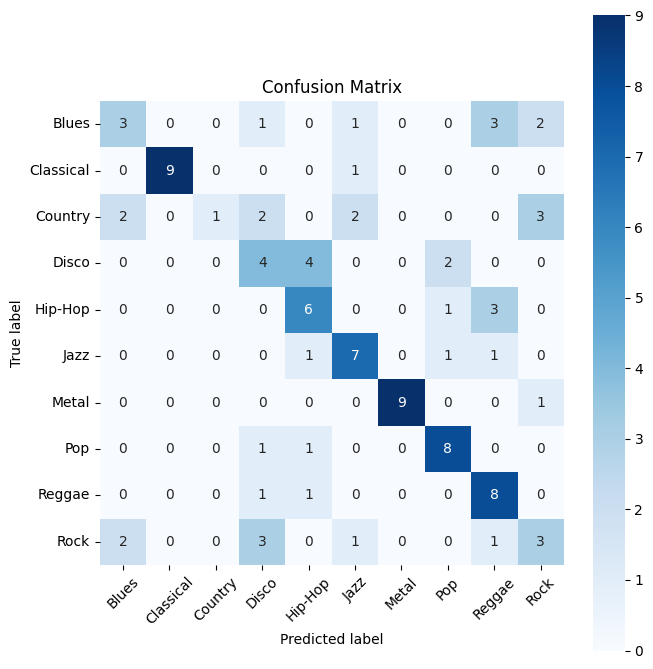

In [51]:
write_results_report_to_new_file(report_output_dirs['gtzan_multi'], EPOCHS_GTZAN_MULTI, results, gtzan_classes)

# Create FMA-small DataLoaders

With val

In [ ]:
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
fma_small_train_dl = prepare_dataloader_based_on_df(fma_small_train_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_val_dl = prepare_dataloader_based_on_df(fma_small_val_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_test_dl = prepare_dataloader_based_on_df(fma_small_test_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)

# Create and train FMA-small model

In [ ]:
EPOCHS_FMA_SMALL_MULTI = 25

In [ ]:
model_fma_small = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(fma_small_top_classes)).to(device)

In [ ]:
fma_small_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(fma_small_top_classes))
fma_small_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(fma_small_top_classes))

In [ ]:
training_loop(model=model_fma_small,
              epochs=EPOCHS_FMA_SMALL_MULTI,
              basic_metrics=fma_small_basic_multiclass_metrics,
              class_names=fma_small_top_classes,
              train_dl=fma_small_train_dl,
              val_dl=fma_small_val_dl,
              full_metrics=fma_small_full_multiclass_metrics)

In [ ]:
results_fma_small = test_loop(model_fma_small, fma_small_full_multiclass_metrics, fma_small_top_classes, fma_small_test_dl)

In [ ]:
write_results_report_to_new_file(report_output_dirs['fma_small_multi'], EPOCHS_FMA_SMALL_MULTI, results_fma_small, fma_small_top_classes)

# Create FMA-medium DataLoaders

With val

In [ ]:
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
fma_medium_train_dl = prepare_dataloader_based_on_df(fma_medium_train_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)
fma_medium_val_dl = prepare_dataloader_based_on_df(fma_medium_val_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)
fma_medium_test_dl = prepare_dataloader_based_on_df(fma_medium_test_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)

# Create and train FMA-medium model

In [ ]:
EPOCHS_FMA_MEDIUM_MULTI = 25

In [ ]:
model_fma_medium = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(fma_medium_top_classes)).to(device)

In [ ]:
fma_medium_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(fma_medium_top_classes))
fma_medium_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(fma_medium_top_classes))

In [ ]:
training_loop(model=model_fma_medium,
              epochs=EPOCHS_FMA_MEDIUM_MULTI,
              basic_metrics=fma_medium_basic_multiclass_metrics,
              class_names=fma_medium_top_classes,
              train_dl=fma_medium_train_dl,
              val_dl=fma_medium_val_dl,
              full_metrics=fma_medium_full_multiclass_metrics)

In [ ]:
results_fma_medium = test_loop(model_fma_medium, fma_medium_full_multiclass_metrics, fma_medium_top_classes, fma_medium_test_dl)

In [ ]:
write_results_report_to_new_file(report_output_dirs['fma_medium_multi'], EPOCHS_FMA_MEDIUM_MULTI, results_fma_medium, fma_medium_top_classes)

# Function definition for binary classification

In [57]:
def trim_dataframe_to_binary_classification(df, class1, class2):
    return df[(df['genre'] == class1) | (df['genre'] == class2)]

# GTZAN binary classification

Best classes: Classical, Pop

In [58]:
EPOCHS_GTZAN_BINARY = 2

In [59]:
BATCH_SIZE = 32
CHANNELS = 3

In [60]:
GTZAN_CLASS_1 = 'Classical'
GTZAN_CLASS_2 = 'Metal'
gtzan_2_classes = [GTZAN_CLASS_1, GTZAN_CLASS_2]

In [61]:
gtzan_2_train_df = trim_dataframe_to_binary_classification(gtzan_train_df, *gtzan_2_classes)
gtzan_2_val_df = trim_dataframe_to_binary_classification(gtzan_val_df,  *gtzan_2_classes)
gtzan_2_test_df = trim_dataframe_to_binary_classification(gtzan_test_df,  *gtzan_2_classes)

In [62]:
gtzan_2_train_dl = prepare_dataloader_based_on_df(gtzan_2_train_df, gtzan_2_classes, BATCH_SIZE, CHANNELS)
gtzan_2_val_dl = prepare_dataloader_based_on_df(gtzan_2_val_df, gtzan_2_classes, BATCH_SIZE, CHANNELS)
gtzan_2_test_dl = prepare_dataloader_based_on_df(gtzan_2_test_df, gtzan_2_classes, BATCH_SIZE, CHANNELS)

In [63]:
model_gtzan_2 = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [64]:
basic_metrics_2 = create_basic_binary_metrics()
full_metrics_2 = create_full_binary_metrics()

TRAINING=======
[EPOCH 1], LOSS: 0.41830230578780175
accuracy: 0.7625
f1: 0.7324
VALIDATION=======
accuracy: 0.5000
f1: 0.6667
TRAINING=======
[EPOCH 2], LOSS: 0.06367339938879013
accuracy: 0.9812
f1: 0.9816
VALIDATION=======
accuracy: 0.5000
f1: 0.6667
precision: 0.5000
recall: 1.0000
cohen's kappa: 0.0000
binary_ROC-AUC: 1.0000


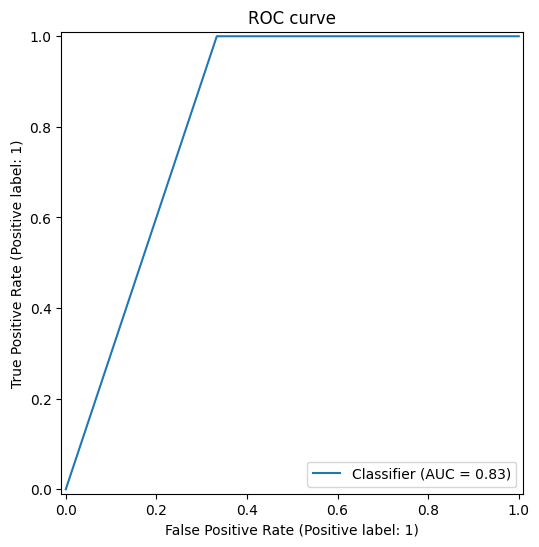

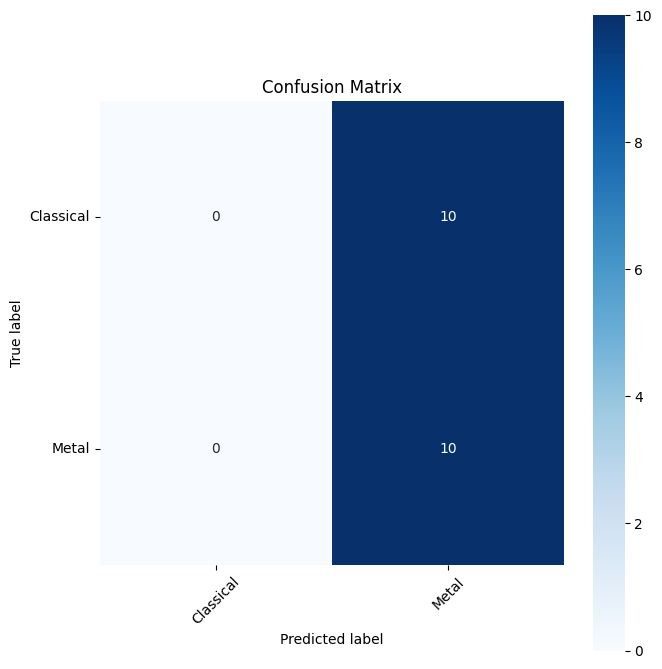

In [65]:
training_loop(model=model_gtzan_2,
              epochs=EPOCHS_GTZAN_BINARY,
              basic_metrics=basic_metrics_2,
              class_names=gtzan_2_classes,
              train_dl=gtzan_2_train_dl,
              val_dl=gtzan_2_val_dl,
              full_metrics=full_metrics_2)

accuracy: 0.5000
f1: 0.6667
precision: 0.5000
recall: 1.0000
cohen's kappa: 0.0000
binary_ROC-AUC: 1.0000


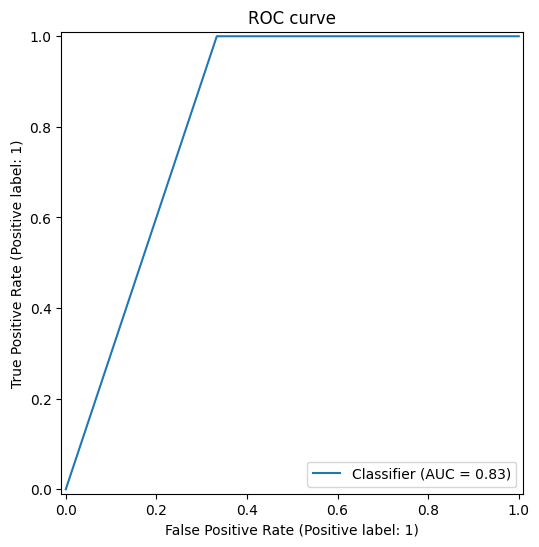

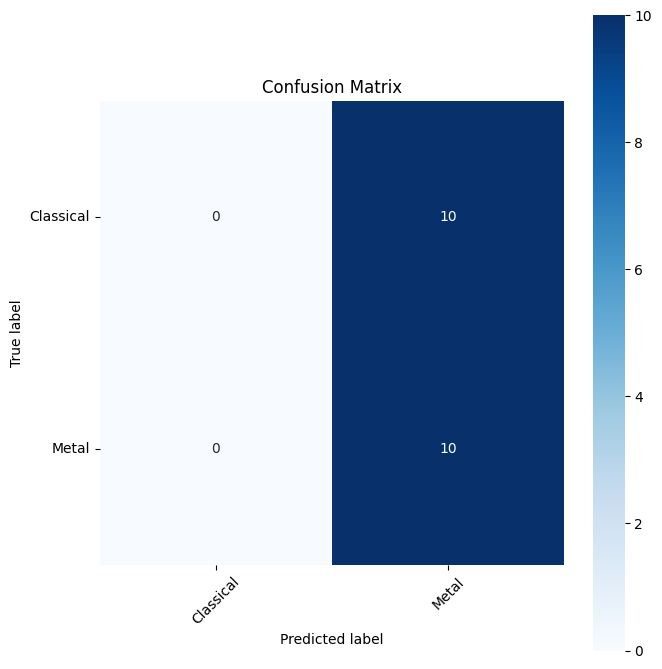

In [66]:
results_gtzan_2 = test_loop(model_gtzan_2, full_metrics_2, gtzan_2_classes, gtzan_2_test_dl)

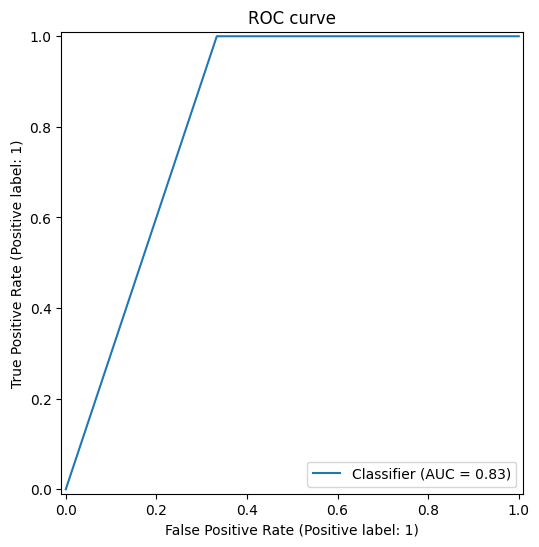

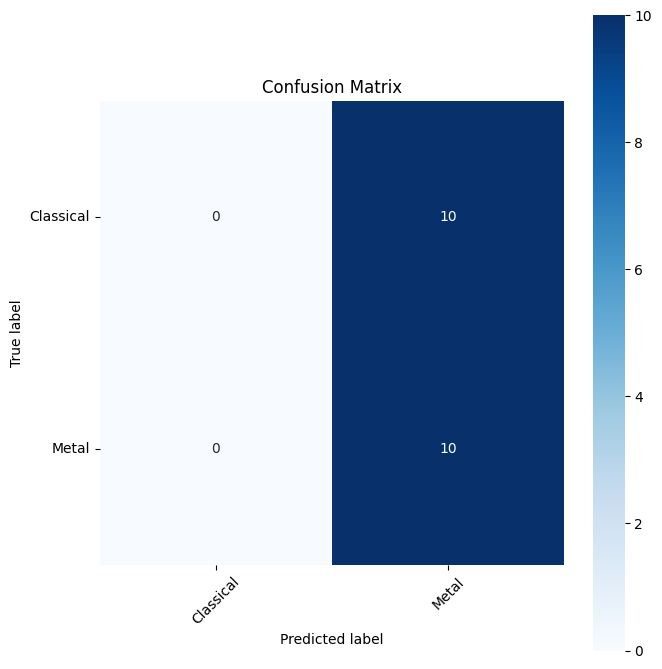

In [67]:
write_results_report_to_new_file(report_output_dirs['gtzan_binary'], EPOCHS_GTZAN_BINARY, results_gtzan_2, gtzan_2_classes)

# FMA-small binary classification

Best classes:

In [ ]:
FMA_SMALL_GTZAN_BINARY = 15

In [ ]:
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
FMA_SMALL_CLASS_1 = 'Rock'
FMA_SMALL_CLASS_2 = 'Pop'
fma_small_2_classes = [FMA_SMALL_CLASS_1, FMA_SMALL_CLASS_2]

In [ ]:
fma_small_2_train_df = trim_dataframe_to_binary_classification(fma_small_train_df, *fma_small_2_classes)
fma_small_2_val_df = trim_dataframe_to_binary_classification(fma_small_val_df,  *fma_small_2_classes)
fma_small_2_test_df = trim_dataframe_to_binary_classification(fma_small_test_df,  *fma_small_2_classes)

In [ ]:
fma_small_2_train_dl = prepare_dataloader_based_on_df(fma_small_2_train_df, fma_small_2_classes, BATCH_SIZE, CHANNELS)
fma_small_2_val_dl = prepare_dataloader_based_on_df(fma_small_2_val_df, fma_small_2_classes, BATCH_SIZE, CHANNELS)
fma_small_2_test_dl = prepare_dataloader_based_on_df(fma_small_2_test_df, fma_small_2_classes, BATCH_SIZE, CHANNELS)

In [ ]:
model_fma_small_2 = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [50]:
basic_metrics_2 = create_basic_binary_metrics()
full_metrics_2 = create_full_binary_metrics()

In [ ]:
training_loop(model=model_fma_small_2,
              epochs=FMA_SMALL_GTZAN_BINARY,
              basic_metrics=basic_metrics_2,
              class_names=fma_small_2_classes,
              train_dl=fma_small_2_train_dl,
              val_dl=fma_small_2_val_dl,
              full_metrics=full_metrics_2)

In [ ]:
results_fma_small_2 = test_loop(model_fma_small_2, full_metrics_2, fma_small_2_classes, fma_small_2_test_dl)

In [ ]:
write_results_report_to_new_file(report_output_dirs['fma_small_binary'], FMA_SMALL_GTZAN_BINARY, results_fma_small_2, fma_small_2_classes)

# FMA-medium binary classification

Best classes: 

In [ ]:
FMA_MEDIUM_GTZAN_BINARY = 15

In [ ]:
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
FMA_MEDIUM_CLASS_1 = 'Rock'
FMA_MEDIUM_CLASS_2 = 'Pop'
fma_medium_2_classes = [FMA_MEDIUM_CLASS_1, FMA_MEDIUM_CLASS_2]

In [ ]:
fma_medium_2_train_df = trim_dataframe_to_binary_classification(fma_medium_train_df, *fma_medium_2_classes)
fma_medium_2_val_df = trim_dataframe_to_binary_classification(fma_medium_val_df,  *fma_medium_2_classes)
fma_medium_2_test_df = trim_dataframe_to_binary_classification(fma_medium_test_df,  *fma_medium_2_classes)

In [ ]:
fma_medium_2_train_dl = prepare_dataloader_based_on_df(fma_medium_2_train_df, fma_medium_2_classes, BATCH_SIZE, CHANNELS)
fma_medium_2_val_dl = prepare_dataloader_based_on_df(fma_medium_2_val_df, fma_medium_2_classes, BATCH_SIZE, CHANNELS)
fma_medium_2_test_dl = prepare_dataloader_based_on_df(fma_medium_2_test_df, fma_medium_2_classes, BATCH_SIZE, CHANNELS)

In [ ]:
model_fma_medium_2 = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [ ]:
basic_metrics_2 = create_basic_binary_metrics()
full_metrics_2 = create_full_binary_metrics()

In [ ]:
training_loop(model=model_fma_medium_2,
              epochs=FMA_MEDIUM_GTZAN_BINARY,
              basic_metrics=basic_metrics_2,
              class_names=fma_medium_2_classes,
              train_dl=fma_medium_2_train_dl,
              val_dl=fma_medium_2_val_dl,
              full_metrics=full_metrics_2)

In [ ]:
results_fma_medium_2 = test_loop(model_fma_medium_2, full_metrics_2, fma_medium_2_classes, fma_medium_2_test_dl)

In [ ]:
write_results_report_to_new_file(report_output_dirs['fma_medium_binary'], FMA_MEDIUM_GTZAN_BINARY, results_fma_medium_2, fma_medium_2_classes)